### Merging segments to improve disconnected trees in the initial neuron reconstruction
* A random forest classifier is trained to predict whether nearby pairs of connected component should be merged.
* Only segments of the same type, axon or dendrite, are considered for merging.

In [1]:
import os
import numpy as np
import pandas as pd
from neuron_morphology.morphology import Morphology
from neuron_morphology.swc_io import morphology_from_swc, morphology_to_swc
from sklearn.neighbors import KDTree
from scipy.spatial.distance import euclidean
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from collections import deque
from joblib import dump, load
import copy
import shutil
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

#### Functions used to find pairs of segment endpoints, calculate features, run prediction using pre-trained classifier, and merge pairs with probability above a certain threshold

In [2]:
def distance(node1, node2, pxl_xyz):
    node1_coord = np.array((node1['x'], node1['y'], node1['z'])) * pxl_xyz
    node2_coord = np.array((node2['x'], node2['y'], node2['z'])) * pxl_xyz
    return euclidean(node1_coord, node2_coord)

def get_nodes(segment, end_node, n):
    nodes = [end_node]
    i = 0
    if end_node['parent'] != -1:
        while i < n:
            next_node = [node for node in segment if node['id'] == nodes[-1]['parent']]
            if next_node == []:
                i = n
            else:
                nodes.append(next_node[0])
            i += 1
    else:
        while i < n:
            next_node = [node for node in segment if node['parent'] == nodes[-1]['id']]
            if next_node == []:
                i = n
            elif len(next_node) > 1:
                i = n
            else:
                nodes.append(next_node[0])
            i += 1
    return nodes

def calculate_vector(nodes, pxl_xyz):
    nodes_coord = np.vstack([np.array((node['x'], node['y'], node['z'])) * pxl_xyz for node in nodes])
    nodes_coord_mean = nodes_coord.mean(axis=0)
    _, _, vv = np.linalg.svd(nodes_coord - nodes_coord_mean)
    vector = vv[0]

    # Fix wrong orientation (sign) of vector
    vect_diff = (nodes_coord[-1, :] - nodes_coord[0, :]) / np.linalg.norm(nodes_coord[-1, :] - nodes_coord[0, :])
    if np.dot(-vector, vect_diff) > np.dot(vector, vect_diff):
        vector *= -1
    return vector

def collinearity(segments, end_nodes, pxl_xyz, num_nodes=[9, 99]):
    end_coord = [np.array((node['x'], node['y'], node['z'])) * pxl_xyz for node in end_nodes]
    cvect = end_coord[1] - end_coord[0]
    cvect_norm = np.linalg.norm(cvect)
    if cvect_norm != 0:
        cvect = cvect / cvect_norm
        cf = []
        for num in num_nodes:
            vectors = []
            for n in range(len(end_nodes)):
                nodes = get_nodes(segments[n], end_nodes[n], num)
                vect = calculate_vector(nodes, pxl_xyz)
                vectors.append(vect)

            cf.append(np.dot(-vectors[0], cvect))
            cf.append(np.dot(vectors[1], cvect))
    else:
        cf = [np.NaN, np.NaN]
    return cf

def collinearity_soma(segment, end_node, soma_node, pxl_xyz, num_nodes = [9,99]):
    end_coord = np.array([end_node['x'], end_node['y'], end_node['z']])*pxl_xyz
    soma_coord = np.array([soma_node['x'], soma_node['y'], soma_node['z']])*pxl_xyz
    cvect = soma_coord - end_coord
    cvect_norm = np.linalg.norm(cvect)
    if cvect_norm != 0:
        cvect = cvect/cvect_norm
        cf = []
        for num in num_nodes:
            nodes = get_nodes(segment, end_node, num)
            vector = calculate_vector(nodes, pxl_xyz)
            
            cf.append(np.dot(-vector, cvect))
    else:
        cf = [np.NaN, np.NaN]
    return cf    

def calculate_features(tree1, end1, tree2, end2, pxl_xyz):
    dist = distance(end1, end2, pxl_xyz)
    treelist = [tree1, tree2]
    endlist = [end1, end2]
    cfactors = collinearity(treelist, endlist, pxl_xyz)
    return np.array([dist] + cfactors)

def find_pairs(fname, sc, cl, pxl_xyz, thresh, ntype=None, radius=range(0, 60, 20)):
    print('thresh', thresh, 'radius', radius)
    morph = morphology_from_swc(fname)
    if ntype:
        print('node type', ntype)
        nodes_by_type = morph.get_node_by_types(node_types=[1, ntype])
        morph = Morphology(nodes_by_type,
                           node_id_cb=lambda node: node['id'],
                           parent_id_cb=lambda node: node['parent'])
    else:
        print('all node types')
    leaf_nodes = morph.get_leaf_nodes()
    tree_list = morph.get_tree_list()

    # For every tree find end nodes (root node(s) and leaf nodes)
    end_node_list = []
    idx_list = []
    for i, tree in enumerate(tree_list):
        root_node = morph.get_roots_for_nodes(tree)[0]
        if root_node['type'] != 1:  # exclude soma node
            idx_list.append(i)
            end_node_list.append(root_node)
        tree_leaf_nodes = [node for node in tree if node in leaf_nodes]
        for node in tree_leaf_nodes:
            idx_list.append(i)
            end_node_list.append(node)
    idx_arr = np.array(idx_list)
    end_node_coord = np.array([np.array((node['x'] * pxl_xyz[0], node['y'] * pxl_xyz[1],
                                         node['z'] * pxl_xyz[2])) for node in end_node_list])
    print('end_node_coord', end_node_coord.shape)
    if len(end_node_coord) == 0:
        print('no nodes of type %d' % ntype)
        return
    # Precompute kdtrees
    kdtree_list = []
    lentree_list = []
    for idx1, tree in enumerate(tree_list):
        s1 = np.where(idx_arr == idx1)[0]  
        s2 = np.where(idx_arr != idx1)[0]  
        if len(s2) > 0:
            kdtree_list.append(KDTree(end_node_coord[s2], leaf_size=2))
        else:
            kdtree_list.append(None)
        lentree_list.append(len(end_node_coord[s2]))

    farray = np.zeros((len(end_node_list), len(end_node_list), 5))
    n = 0
    num_ends = 5
    num_ends_r = 30
    if len(end_node_coord) > 2500:
        num_ends_r = 10
    pair_data = []
    for idx1, tree in enumerate(tree_list):
        s1 = np.where(idx_arr == idx1)[0]
        s2 = np.where(idx_arr != idx1)[0]
        kdtree = kdtree_list[idx1]
        if kdtree:
            lentree = lentree_list[idx1]
            for s in s1:
                # Find closest ends
                min_dist_idx, dist = kdtree.query_radius(end_node_coord[s].reshape(1, 3), radius[-1],
                                                         return_distance=True, sort_results=True)
                select = []
                for i in range(len(radius) - 1):
                    select.append(np.where((dist[0] > radius[i]) & (dist[0] <= radius[i + 1])))
                for l in select:
                    p_arr = s2[min_dist_idx[0][l[0][:num_ends_r]]]
                    idx2_arr = idx_arr[p_arr]
                    if len(p_arr) > 0:
                        probs = np.zeros((len(p_arr),))
                        nodes = np.empty((len(p_arr),), dtype=object)
                        features = np.empty((len(p_arr),), dtype=object)
                        for i, p in enumerate(p_arr):
                            # First 5 features
                            if farray[s, p, 0] == 0:
                                f = calculate_features(tree_list[idx1], end_node_list[s],
                                                       tree_list[idx2_arr[i]], end_node_list[p], pxl_xyz)
                                farray[s, p, :] = f
                            else:
                                f = farray[s, p, :]

                            # 5 x (num_ends-1) features for 1st end
                            dist1, min_dist_idx1 = kdtree.query(end_node_coord[s].reshape(1, 3), k=min(num_ends, lentree))
                            q_arr = s2[min_dist_idx1[0]]
                            s3 = np.where(q_arr != p)[0][0:num_ends - 1]
                            q_arr = q_arr[s3]
                            q_arr = q_arr[:num_ends - 1]
                            dist1 = dist1[:, s3]
                            idx3_arr = idx_arr[q_arr]
                            for j, q in enumerate(q_arr):
                                if farray[s, q, 0] == 0:
                                    f1 = calculate_features(tree_list[idx1], end_node_list[s],
                                                            tree_list[idx3_arr[j]], end_node_list[q], pxl_xyz)
                                    farray[s, q, :] = f1
                                else:
                                    f1 = farray[s, q, :]
                                f = np.concatenate((f, f1))
                            if lentree < num_ends:
                                f1 = np.array([1000, -1, -1, -1, -1] * (num_ends - lentree))
                                f = np.concatenate((f, f1))
                            # 5 x (num_ends-1) features for 2nd end
                            s3 = np.where(idx_arr != idx2_arr[i])[0]
                            kdtree1 = kdtree_list[idx2_arr[i]]
                            lentree1 = lentree_list[idx2_arr[i]]
                            dist1, min_dist_idx1 = kdtree1.query(end_node_coord[p].reshape(1, 3), k=min(num_ends, lentree1))
                            q_arr = s3[min_dist_idx1[0]]
                            s4 = np.where(q_arr != s)[0][0:num_ends - 1]
                            q_arr = q_arr[s4]
                            q_arr = q_arr[:num_ends - 1]
                            dist1 = dist1[:, s4]
                            idx3_arr = idx_arr[q_arr]
                            for j, q in enumerate(q_arr):
                                if farray[p, q, 0] == 0:
                                    f1 = calculate_features(tree_list[idx2_arr[i]], end_node_list[p],
                                                            tree_list[idx3_arr[j]], end_node_list[q], pxl_xyz)
                                    farray[p, q, :] = f1
                                else:
                                    f1 = farray[p, q, :]
                                f = np.concatenate((f, f1))
                            if lentree1 < num_ends:
                                f1 = np.array([1000, -1, -1, -1, -1] * (num_ends - lentree1))
                                f = np.concatenate((f, f1))
                            features[i] = f
                            # For every pair predict prob
                            x = sc.transform(f.reshape(1, -1))
                            probs[i] = cl.predict_proba(x)[0][1]
                        # Find pair with max prob
                        probs_max = np.max(probs)
                        k_max = np.argmax(probs)
                        if probs_max >= thresh:
                            pair_dict = {}
                            pair_dict['idx'] = n
                            pair_dict['tree1'] = idx1
                            pair_dict['tree2'] = idx2_arr[k_max]
                            pair_dict['nid1'] = end_node_list[s]['id']
                            pair_dict['pid1'] = end_node_list[s]['parent']
                            pair_dict['nid2'] = end_node_list[p_arr[k_max]]['id']
                            pair_dict['pid2'] = end_node_list[p_arr[k_max]]['parent']
                            pair_dict['prob'] = probs_max
                            for i in range(num_ends * 2 - 1):
                                pair_dict['distance%d' % i] = features[k_max][i * 5]
                                pair_dict['cf0_near%d' % i] = features[k_max][i * 5 + 1]
                                pair_dict['cf1_near%d' % i] = features[k_max][i * 5 + 2]
                                pair_dict['cf0_far%d' % i] = features[k_max][i * 5 + 3]
                                pair_dict['cf1_far%d' % i] = features[k_max][i * 5 + 4]
                            pair_data.append(pair_dict)
                            n += 1
                            break
    print('pair_data', len(pair_data))
    return pair_data

def remove_duplicates(pair_data):
    t1 = [pair['tree1'] for pair in pair_data]
    t2 = [pair['tree2'] for pair in pair_data]
    num_tree = max(max(t1), max(t2)) + 1
    dupl_list = []
    # Remove duplicates (same pair (tree1, tree2))
    for i in range(num_tree):
        select1 = [pair_data.index(p) for p in pair_data if p['tree1'] == i]
        js = [pair_data[s1]['tree2'] for s1 in select1]
        js_unique = np.unique(js)
        for j in js_unique:
            s2 = np.where(js == j)[0]
            if len(s2) > 1:
                probs = [pair_data[select1[s]]['prob'] for s in s2]
                idx = np.argmax(probs)
                for k, s in enumerate(s2):
                    if k != idx:
                        dupl_list.append(select1[s])
    pair_data1 = [pair_data[i] for i in range(len(pair_data)) if i not in dupl_list]
    if not pair_data1:
        return

    dupl_list = []
    # Remove duplicates (tree1<->tree2)
    for i in range(num_tree):
        select1 = [pair_data1.index(p) for p in pair_data1 if p['tree1'] == i]
        for s1 in select1:
            j = pair_data1[s1]['tree2']
            select2 = [pair_data1.index(p) for p in pair_data1 if p['tree1'] == j]
            for s2 in select2:
                k = pair_data1[s2]['tree2']
                if k == i:
                    if pair_data1[s1]['prob'] < pair_data1[s2]['prob']:
                        dupl_list.append(s1)
                    elif pair_data1[s1]['prob'] > pair_data1[s2]['prob']:
                        dupl_list.append(s2)
                    else:
                        dupl_list.append(max(s1, s2))

    pair_data1 = [pair_data1[i] for i in range(len(pair_data1)) if i not in dupl_list]
    if not pair_data1:
        return

    # Remove duplicates (end0->end1, end1->end2)
    n1 = [pair['nid1'] for pair in pair_data1]
    n2 = [pair['nid2'] for pair in pair_data1]
    num_nid = max(max(n1), max(n2)) + 1
    dupl_list = []
    for i in range(num_nid):
        select = []
        select1 = [pair_data1.index(p) for p in pair_data1 if p['nid1'] == i]
        if len(select1) > 0:
            for s1 in select1:
                select.append(s1)
        select2 = [pair_data1.index(p) for p in pair_data1 if p['nid2'] == i]
        if len(select2) > 0:
            for s2 in select2:
                select.append(s2)
        if len(select) > 1:
            probs = [pair_data1[s]['prob'] for s in select]
            idx = np.argmax(probs)
            for k, s in enumerate(select):
                if k != idx:
                    dupl_list.append(s)
    pair_data1 = [pair_data1[i] for i in range(len(pair_data1)) if i not in dupl_list]
    print('pair_data', len(pair_data1))
    return pair_data1

def reroot_tree(start_node, tree, morph):
    # Create neighbors dict
    neighbors_dict = {}
    for node in tree:
        node_neighbors = []
        parent = morph.parent_of(node)
        if parent != None:
            node_neighbors.append(parent)
        children = morph.get_children(node)
        for ch in children:
            node_neighbors.append(ch)
        neighbors_dict[node['id']] = node_neighbors
    start_node_parent = -1
    # Assign parent-child relation
    parent_dict = {}
    parent_dict[start_node['id']] = start_node_parent
    queue = deque([start_node])
    while len(queue) > 0:
        current_node = queue.popleft()
        neighbors = neighbors_dict[current_node['id']]
        for node in neighbors:
            if node['id'] not in parent_dict:
                parent_dict[node['id']] = current_node['id']
                queue.append(node)
    # Change node parents
    new_tree = copy.deepcopy(tree)
    for node in new_tree:
        node['parent'] = parent_dict[node['id']]
    return new_tree

def connect_trees(nodes, morph_in):
    tree_list = morph_in.get_tree_list()
    # Find trees containing nodes in tree_list
    n = 0
    for i, tree in enumerate(tree_list):
        if nodes[0] in tree:
            tree1 = copy.deepcopy(tree)
            idx1 = i
            n += 1
        if nodes[1] in tree:
            tree2 = copy.deepcopy(tree)
            idx2 = i
            n += 1
        if n == 2:
            break
    if idx1 != idx2:
        i1 = tree1.index(nodes[0])
        if nodes[0]['parent'] == -1:
            # Reroot using any leaf node
            leaf_nodes = morph_in.get_leaf_nodes()
            tree_leaf_nodes = [node for node in tree1 if node in leaf_nodes]
            if len(tree_leaf_nodes) == 0:
                print('do not reroot')
            else:
                tree1 = reroot_tree(tree_leaf_nodes[0], tree1, morph_in)

        i2 = tree2.index(nodes[1])
        # If end node is leaf, reroot tree2
        if nodes[1]['parent'] != -1:
            # Reroot using end node
            tree2 = reroot_tree(nodes[1], tree2, morph_in)
        # connect tree2 to tree1
        tree2[i2]['parent'] = tree1[i1]['id']
        tree_list[idx1] = tree1
        tree_list[idx2] = tree2
        # Update morph
        tree_nodes = [node for tree in tree_list for node in tree]
        morph_out = Morphology(tree_nodes,
                               node_id_cb=lambda node: node['id'],
                               parent_id_cb=lambda node: node['parent'])
    else:
        print('loop, do not connect')
        morph_out = morph_in
    return morph_out

def connect_to_soma(nodes, morph_in, pxl_xyz, len_thresh=100, cthresh=0.26):
    tree_list = morph_in.get_tree_list()
    soma_node = morph_in.get_soma()
    # Find trees containing nodes in tree_list
    n = 0
    tree_list1 = [[],[]]
    idx = np.zeros((2,), dtype=np.uint64)
    for i, tree in enumerate(tree_list):
        for j, node in enumerate(nodes):
            if node in tree:
                tree_list1[j] = copy.deepcopy(tree)
                idx[j] = i
                n += 1
        if soma_node in tree:
            idx_soma = i
            n += 1
        if n == 3:
            break        
    connect = 0    
    if idx[0] != idx[1]:
        for j, tree in enumerate(tree_list1):
            k = tree.index(nodes[j])
            if idx[j] != idx_soma:
                if len(tree) > len_thresh:
                    cfactors = collinearity_soma(tree, nodes[j], soma_node, pxl_xyz)
                    if min(cfactors) > cthresh:
                        print('connect end to soma')
                        if nodes[j]['parent'] != -1:
                            # Reroot using end node
                            tree = reroot_tree(nodes[j], tree, morph_in)                    
                        # connect tree to soma
                        tree[k]['parent'] = soma_node['id']
                        tree_list[idx[j]] = tree
                        connect = 1
            else:
                print('loop, do not connect')
        
        if connect == 1:
            # Update morph
            tree_nodes = [node for tree in tree_list for node in tree]
            morph_out = Morphology(tree_nodes,
                        node_id_cb=lambda node: node['id'],
                        parent_id_cb=lambda node: node['parent'])
        else:
            morph_out = morph_in
    else:
        print('loop, do not connect')
        morph_out = morph_in
    return morph_out    

def dfs_labeling(st_node, new_starting_id, modifying_dict, morph):
    ct = 0
    queue = deque([st_node])
    while len(queue) > 0:
        ct += 1
        current_node = queue.popleft()
        modifying_dict[current_node['id']] = new_starting_id
        new_starting_id += 1
        for ch_no in morph.get_children(current_node):
            queue.appendleft(ch_no)
    return ct

def sort_swc(infile, outfile):
    morph = morphology_from_swc(infile)
    unordered_swc_info = {}
    with open(infile, 'r') as f:
        for l in f:
            if '#' not in l:
                no_id = int(l.split(' ')[0])
                parent_id = l.split()[-1]
                children_list = morph.get_children(morph.node_by_id(no_id))
                unordered_swc_info[no_id] = l
    new_node_ids = {}
    start_label = 1
    for root in morph.get_roots():
        seg_len = dfs_labeling(root, start_label, new_node_ids, morph)
        start_label += seg_len

    new_output_dict = {}
    for old_id, old_line in unordered_swc_info.items():
        new_id = new_node_ids[old_id]
        old_parent = int(old_line.split()[-1])
        if old_parent == -1:
            new_parent = -1
        else:
            new_parent = new_node_ids[old_parent]

        new_line_list = [str(new_id)] + old_line.split(' ')[1:-1] + ['{}\n'.format(new_parent)]
        new_line = " ".join(new_line_list)
        new_output_dict[new_id] = new_line

    with open(outfile, "w") as f2:
        for k in sorted(list(new_output_dict.keys())):
            new_write_line = new_output_dict[k]
            f2.write(new_write_line)

def merge_pairs(infile, outfile, csvfile, pxl_xyz, thresh, ntype=None):
    if csvfile:
        # Load pair_data
        dfp = pd.read_csv(csvfile)
        pair_data = dfp.to_dict('records')
        print(len(pair_data))
    # Load morph
    morph = morphology_from_swc(infile)
    if ntype:
        print('node type', ntype)
        nodes_by_type = morph.get_node_by_types(node_types=[1,ntype])
        morph = Morphology(nodes_by_type,
                    node_id_cb=lambda node: node['id'],
                    parent_id_cb=lambda node: node['parent'])
        if not csvfile:
            print('no pairs')
            morphology_to_swc(morph, outfile)
            return
    else:
        print('all node types')
    tree_list = morph.get_tree_list()
    soma_node = morph.get_soma()
    pair_idx = np.arange(0,len(tree_list))
    if soma_node not in tree_list[0]:
        print('soma is not in tree 0')
        for i, tree in enumerate(tree_list):
            if soma_node in tree:
                soma_idx = i
                print('soma in tree %d'%i)
                pair_idx = np.delete(pair_idx,i)
                pair_idx = np.hstack((i, pair_idx))
                break
    # Start merging with tree containing soma node
    idx_list = []
    for i in pair_idx:
        # Find pairs with tree i
        select = [pair_data.index(p) for p in pair_data if p['tree1'] == i] + \
                    [pair_data.index(p) for p in pair_data if p['tree2'] == i]      
        for s in select:
            if pair_data[s]['prob'] > thresh:
                if s not in idx_list:
                    connect = 0
                    # Check features if morph is bent (optional)
                    cfactors = np.array([pair_data[s]['cf0_near0'], pair_data[s]['cf1_near0'],
                                        pair_data[s]['cf0_far0'], pair_data[s]['cf1_far0']])
                    if len(np.where(cfactors < -1)[0]): # -1 -> do not exclude
                        print('idx %d'%(pair_data[s]['idx']), cfactors)
                    else:
                        end_nodes = (morph.node_by_id(pair_data[s]['nid1']),
                                    morph.node_by_id(pair_data[s]['nid2']))
                        soma_node = morph.get_soma()
                        dist_to_soma = [distance(node, soma_node, pxl_xyz) for node in end_nodes]
                        if min(dist_to_soma) > 30:
                            connect = 1
                    if connect == 1:    
                        # Connect segments
                        morph = connect_trees(end_nodes, morph)
                        idx_list.append(s)
        
    print('idx_list', len(idx_list))
    # Reroot tree containing soma, so soma is a root
    # Rearange tree_list, so soma node in the 1st tree
    soma_node = morph.get_soma()
    tree_list = morph.get_tree_list()
    for i, tree in enumerate(tree_list):
        if soma_node in tree:
            soma_idx = i
            print('soma in tree %d'%soma_idx)
            break
    new_tree = reroot_tree(soma_node, tree_list[soma_idx], morph)
    del tree_list[soma_idx]
    tree_list = [new_tree] + tree_list
    tree_nodes = [node for tree in tree_list for node in tree]
    morph = Morphology(tree_nodes,
                node_id_cb=lambda node: node['id'],
                parent_id_cb=lambda node: node['parent'])
    # Save new morphology
    morphology_to_swc(morph, outfile) 
    sort_swc(outfile, outfile)

def combine_compartments(infile_list, outfile):
    nodes_list = []
    offset = 0
    for i, infile in enumerate(infile_list):
        morph = morphology_from_swc(infile)
        nodes = morph.nodes()
        soma_nodes = morph.get_node_by_types(node_types=[1])
        if i == 0:
            soma_node = soma_nodes[0]
            soma_node_children = [n for node in soma_nodes for n in morph.get_children(node)]
        else:
            soma_node_children = [n for node in soma_nodes for n in morph.get_children(node)]
            for node in nodes:
                if node in soma_node_children:
                    node['parent'] = soma_node['id']
            # Delete soma_node
            nodes = [node for node in nodes if node not in soma_nodes]
        if len(nodes) > 0:
            nids = np.array([node['id'] for node in nodes])
            pids = np.array([node['parent'] for node in nodes])
            select1 = np.where(nids != 1)[0]
            select2 = np.where((pids != -1) & (nids != 1))[0]
            nids_new = np.copy(nids)
            nids_new[select1] = nids[select1] + offset - np.min(nids) + 1
            pids_new = np.copy(pids)
            pids_new[select2] = pids[select2] + offset - np.min(nids) + 1
            for j, node in enumerate(nodes):
                node['id'] = nids_new[j]
                if node not in soma_node_children:
                    node['parent'] = pids_new[j]
            offset = np.max(nids_new)
            for node in nodes:
                nodes_list.append(node)
    morph = Morphology(nodes_list,
                       node_id_cb=lambda node: node['id'],
                       parent_id_cb=lambda node: node['parent'])
    morphology_to_swc(morph, outfile)
    sort_swc(outfile, outfile)

def delete_intermediate_files(indir, sp):
    file_list = [os.path.join(indir, f) for f in os.listdir(indir) if ('%s' % sp in f) & ('iter' in f)]
    for f in file_list:
        if os.path.exists(f):
            os.remove(f)

def load_swc(filepath):
    '''
    Load swc file as a N X 7 numpy array
    '''
    swc = []
    with open(filepath) as f:
        lines = f.read().split("\n")
        for l in lines:
            if not l.startswith('#'):
                cells = l.split(' ')
                if len(cells) == 7:
                    cells = [float(c) for c in cells]
                    swc.append(cells)
                elif len(cells) == 8:
                    cells = [float(c) for c in cells[0:7]]
                    swc.append(cells)                
    return np.array(swc)                

#### Running merging segments of initial trace using pre-trained classifier

In [3]:
rootdir = '../..'
datadir = os.path.join(rootdir, 'data')
specimen_id = 861765455
input_dir = os.path.join(datadir, 'dataset', 'merging')
output_dir = os.path.join(rootdir, 'results') 
model_dir = os.path.join(datadir, 'models', 'merging')

In [4]:
def process(specimen_id, input_dir, output_dir, model_dir, by_type):
    input_file = os.path.join(input_dir,'%d.swc'%specimen_id)
    output_file = os.path.join(output_dir,'%d_connect.swc'%specimen_id)
    # Load scaler
    scaler = load(os.path.join(model_dir, 'scaler_45f.joblib'))
    # Load classifier model
    clf = load(os.path.join(model_dir, 'RF_45f_0.joblib')) 
    xyz_pxl = np.array([0.1144, 0.1144, 0.28])
    max_iter = 3
    thresh_list = [0.78, 0.78, 0.78]
    for num_iter in range(1,max_iter+1):
        threshold = thresh_list[num_iter-1]
        print('num_iter', num_iter, 'thresh', threshold, 'input_file', input_file)
        
        if by_type:
            print('Connect nodes by type')
            node_type_list = [2,3]
            k = 0
            for node_type in node_type_list:
                print('node_type', node_type)
                # Find pairs
                pair_data_iter = find_pairs(input_file, scaler, clf, xyz_pxl, threshold, node_type)                   
                
                if pair_data_iter:
                    # Remove duplicates
                    pair_data_iter = remove_duplicates(pair_data_iter)
                    # Save pair_data as csv file
                    df1 = pd.DataFrame.from_dict(pair_data_iter)
                    csv_file = os.path.join(output_dir, 
                                '%d_pair_dict_iter%d_%d.csv'%(specimen_id, num_iter, node_type))
                    df1.to_csv(csv_file, index=False)
                    
                else:
                    k += 1
                    csv_file = None
                
                # Merge segment pairs with prob below thresh
                output_file_iter = os.path.join(output_dir, 
                                '%d_connect_iter%d_%d.swc'%(specimen_id, num_iter, node_type)) 
                merge_pairs(input_file, output_file_iter, csv_file, xyz_pxl, threshold, node_type)
            # Combine swc for all node types
            output_file_iter = os.path.join(output_dir, '%d_connect_iter%d.swc'%(specimen_id, num_iter))
            input_file_list = [os.path.join(output_dir, '%d_connect_iter%d_%d.swc'%(specimen_id, num_iter, node_type)) 
                                for node_type in node_type_list]
            if k == 2:
                print('no pairs')
                shutil.copyfile(input_file, output_file) 
                delete_intermediate_files(output_dir, specimen_id) # optional
                return
            combine_compartments(input_file_list, output_file_iter)
                       
        else:
            print('Connect all nodes')
            # Find pairs
            pair_data_iter = find_pairs(input_file, scaler, clf, xyz_pxl, threshold)
            if not pair_data_iter:
                print('no pairs')
                shutil.copyfile(input_file, output_file) 
                delete_intermediate_files(output_dir, specimen_id) # optional
                return
                           
            # Remove duplicates
            pair_data_iter = remove_duplicates(pair_data_iter)
            
            # Save pair_data as csv file
            df1 = pd.DataFrame.from_dict(pair_data_iter)
            csv_file = os.path.join(output_dir, '%d_pair_dict_iter%d.csv'%(specimen_id, num_iter))
            df1.to_csv(csv_file, index=False)
            
            # Merge segment pairs with prob below thresh
            output_file_iter = os.path.join(output_dir, '%d_connect_iter%d.swc'%(specimen_id, num_iter)) 
            merge_pairs(input_file, output_file_iter, csv_file, threshold)
            
        input_file = output_file_iter
            
        # Save final output swc file
        if num_iter == max_iter:
            shutil.copyfile(output_file_iter, output_file)
#             delete_intermediate_files(output_dir, specimen_id) # optional

In [5]:
process(specimen_id, input_dir, output_dir, model_dir, by_type=True)

num_iter 1 thresh 0.78 input_file ../../data/dataset/merging/861765455.swc
Connect nodes by type
node_type 2
thresh 0.78 radius range(0, 60, 20)
node type 2
end_node_coord (653, 3)
pair_data 222
pair_data 108
108
node type 2
idx_list 104
soma in tree 0
node_type 3
thresh 0.78 radius range(0, 60, 20)
node type 3
end_node_coord (228, 3)
pair_data 25
pair_data 15
15
node type 3
idx_list 14
soma in tree 8
num_iter 2 thresh 0.78 input_file ../../results/861765455_connect_iter1.swc
Connect nodes by type
node_type 2
thresh 0.78 radius range(0, 60, 20)
node type 2
end_node_coord (445, 3)
pair_data 37
pair_data 21
21
node type 2
idx_list 18
soma in tree 0
node_type 3
thresh 0.78 radius range(0, 60, 20)
node type 3
end_node_coord (200, 3)
pair_data 2
pair_data 2
2
node type 3
idx_list 1
soma in tree 0
num_iter 3 thresh 0.78 input_file ../../results/861765455_connect_iter2.swc
Connect nodes by type
node_type 2
thresh 0.78 radius range(0, 60, 20)
node type 2
end_node_coord (409, 3)
pair_data 8
pai

#### Plot manual vs auto initial vs auto connected trace

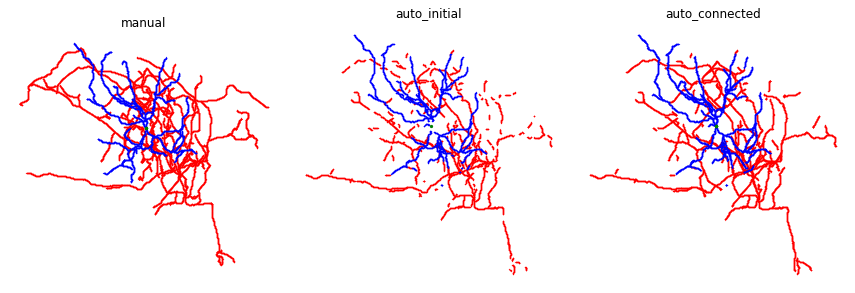

In [6]:
file_list = [os.path.join(input_dir, '%d_manual.swc'%specimen_id),
            os.path.join(input_dir, '%d.swc'%specimen_id),
            os.path.join(input_dir, '%d_connect_resampled.swc'%specimen_id)]

color_dict = {'1': 'g', '2': 'r', '3': 'b', '5': 'k'}
trace_list = []
for f in file_list:
    trace_list.append(load_swc(f))

tlist = ['manual', 'auto_initial', 'auto_connected']
plt.figure(figsize=(12,4))
for i, trace in enumerate(trace_list):
    plt.subplot(1,3,i+1)
    sa = np.where(trace[:,1]==2)
    plt.scatter(trace[sa,2], trace[sa,3], marker = '.', c='r', s=0.1)
    sd = np.where(trace[:,1]==3)
    plt.scatter(trace[sd,2], trace[sd,3], marker = '.', c='b', s=0.1)
    ss = np.where(trace[:,1]==1)
    plt.scatter(trace[ss,2], trace[ss,3], marker = '.', c='g', s=20)
    plt.ylim(plt.ylim()[::-1])
    plt.axis('scaled')
    plt.axis('off')
    plt.title(tlist[i])
plt.tight_layout()
plt.show()    